# Exploratory data analysis

In [1]:
import os
import xarray as xr

import matplotlib.pyplot as plt

In [2]:
%cd /g/data/w42/dr6273/work/demand_model/

/g/data/w42/dr6273/work/demand_model


In [3]:
path = "/g/data/w42/dr6273/work/projects/Aus_energy/"

# Load predictors and predictands

Detrended energy demand (predicand)

In [4]:
dem_da = xr.open_dataset(
    path + "/data/energy_demand/daily_demand_2010-2020_detrended.nc"
)["demand_dt"]

Predictors. Load everything from relevant directory.

In [5]:
files = [path + "demand_predictors/" + i for i in os.listdir(path + "demand_predictors/")]

In [6]:
pred_ds = xr.open_mfdataset(files, combine="nested", compat="override").compute()

In [7]:
pred_ds

<xarray.Dataset>
Dimensions:   (region: 6, time: 23376)
Coordinates:
  * region    (region) object 'NEM' 'NSW' 'VIC' 'QLD' 'SA' 'TAS'
  * time      (time) datetime64[ns] 1959-01-01 1959-01-02 ... 2022-12-31
Data variables: (12/15)
    t2min     (region, time) float64 289.3 289.0 289.3 ... 282.1 287.9 287.9
    t2m3      (region, time) float64 nan nan 293.0 293.7 ... 290.2 287.9 289.7
    msdwswrf  (region, time) float64 nan 293.4 257.6 298.1 ... 281.5 249.9 299.6
    cdd4      (region, time) float64 nan nan nan ... 0.221 0.221 -0.001519
    t2m       (region, time) float64 292.7 292.8 293.6 ... 287.1 289.8 292.2
    cdd3      (region, time) float64 nan nan 0.2243 ... -0.001518 -0.001519
    ...        ...
    mtpr      (region, time) float64 2.842e-05 4.244e-05 ... 1.614e-05 6.045e-06
    rh        (region, time) float64 92.39 91.39 91.05 ... 90.65 93.94 92.18
    w10       (region, time) float64 3.489 3.602 3.166 ... 1.758 3.059 3.369
    t2max     (region, time) float64 297.0 297.5 298.1 ... 291.4 292.7 297.2
    hdd3      (region, time) float64 nan nan 0.5113 0.1891 ... 2.974 3.225 1.994
    t2m4      (region, time) float64 nan nan nan 293.5 ... 290.4 290.1 289.0

In [8]:
pred_ds.data_vars

Data variables:
    t2min     (region, time) float64 289.3 289.0 289.3 ... 282.1 287.9 287.9
    t2m3      (region, time) float64 nan nan 293.0 293.7 ... 290.2 287.9 289.7
    msdwswrf  (region, time) float64 nan 293.4 257.6 298.1 ... 281.5 249.9 299.6
    cdd4      (region, time) float64 nan nan nan ... 0.221 0.221 -0.001519
    t2m       (region, time) float64 292.7 292.8 293.6 ... 287.1 289.8 292.2
    cdd3      (region, time) float64 nan nan 0.2243 ... -0.001518 -0.001519
    cdd       (region, time) float64 0.2308 0.1576 ... -0.001518 -0.001518
    hdd4      (region, time) float64 nan nan nan 0.383 ... 2.467 2.565 2.572
    hdd       (region, time) float64 0.9647 0.4147 0.1544 ... 4.028 1.341 0.6154
    mtpr      (region, time) float64 2.842e-05 4.244e-05 ... 1.614e-05 6.045e-06
    rh        (region, time) float64 92.39 91.39 91.05 ... 90.65 93.94 92.18
    w10       (region, time) float64 3.489 3.602 3.166 ... 1.758 3.059 3.369
    t2max     (region, time) float64 297.0 297.5 29

In [9]:
def ts(ax, da, region):
    """
    Time series plot.
    
    ax: axes to draw on
    ds: dataarray
    region: region name
    """
    da.sel(region=region).plot(ax=ax, alpha=0.7, lw=0.5)
    ax.set_title("")

In [10]:
def scatter(ax, y_da, x_ds, x_var, region):
    """
    Scatter plot of y_da against x_var.
    
    ax: axes to draw on
    y_da: dataarray of predictand
    x_ds: dataset of predictors
    x_var: data_var name
    region: region name
    """
    def K_to_C(da):
        return da - 273.15
    
    x_da = x_ds[x_var]
    if x_var in ["t2m", "t2min", "t2max", "t2m3", "t2m4"]:
        x_da = K_to_C(x_da)
        
    ax.scatter(
        x_da.sel(region=region, time=y_da["time"]),
        y_da.sel(region=region) / 1000,
        s=1,
        alpha=0.3
    )
    ax.set_ylabel("Demand [GWh/day]")
    ax.set_xlabel(x_var)

In [11]:
# Sort the data variables into something more logical
vars_sorted = ["t2m", "t2m3", "t2m4", "t2min", "t2max",
               "cdd", "cdd3", "cdd4",
               "hdd", "hdd3", "hdd4",
               "msdwswrf", "mtpr", "rh", "w10"]

In [12]:
def facet(plot_fn_name, y_da, x_ds, region, filename=None):
    """
    16 subplots - one for each predictor and the predictand.
    
    plot_fn_name: str, 'scatter' or 'ts' to indicate which plotting function to use
    y_da: array of predictand
    x_ds: dataset of predictors
    region: region name
    filename: filename for savefig
    """
    fig, ax = plt.subplots(5, 3, figsize=(7, 9), dpi=100)
    
    for i, v in enumerate(vars_sorted):
        if (i == 0) & (plot_fn_name == "ts"):
            ts(ax[0,0], y_da / 1000, region)
        elif (i > 0) & (plot_fn_name == "ts"):
            ts(ax.flatten()[i], x_ds[v], region)
        elif plot_fn_name == "scatter":
            scatter(ax.flatten()[i], y_da, x_ds, v, region)
        else:
            raise ValueError("Incorrect plot_fn_name")
        
    plt.tight_layout()
    
    if filename is not None:
        plt.savefig("./figures/" + filename, format="pdf", dpi=400, bbox_inches="tight")
        
    plt.close()

In [13]:
for plot_name in ["ts", "scatter"]:
    for region in pred_ds["region"].values:
        fp = plot_name + "_" + region + ".pdf"
        facet(plot_name, dem_da, pred_ds, region, fp)

In [18]:
x = pred_ds.sel(region="NEM").t2m

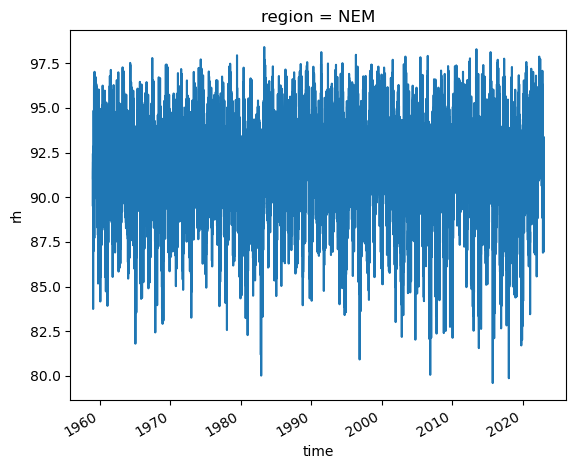

In [19]:
y = pred_ds.sel(region="NEM").rh.plot()

In [ ]:
max_both = xr.ufuncs.sqrt(

In [20]:
721/4

180.25